In [1]:
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
import IPython

In [2]:
# TABLES FROM ISO226 

tbl_f = np.asarray(
    [20, 25, 31.5, 40, 50, 63, 80, 100, 125, 160, 200, 250, 315, 400,
     500, 630, 800, 1000, 1250, 1600, 2000, 2500, 3150, 4000, 5000, 6300,
     8000, 10000, 12500])

tbl_alpha_f = np.asarray(
    [0.532, 0.506, 0.480, 0.455, 0.432, 0.409, 0.387, 0.367, 0.349, 0.330,
     0.315, 0.301, 0.288, 0.276, 0.267, 0.259, 0.253, 0.250, 0.246, 0.244,
     0.243, 0.243, 0.243, 0.242, 0.242, 0.245, 0.254, 0.271, 0.301])

tbl_L_U = np.asarray(
    [-31.6, -27.2, -23.0, -19.1, -15.9, -13.0, -10.3, -8.1, -6.2, -4.5,
     -3.1, -2.0, -1.1, -0.4, 0.0, 0.3, 0.5, 0.0, -2.7, -4.1, -1.0, 1.7,
     2.5, 1.2, -2.1, -7.1, -11.2, -10.7, -3.1])

tbl_T_f = np.asarray(
    [78.5, 68.7, 59.5, 51.1, 44.0, 37.5, 31.5, 26.5, 22.1, 17.9, 14.4,
     11.4, 8.6, 6.2, 4.4, 3.0, 2.2, 2.4, 3.5, 1.7, -1.3, -4.2, -6.0, -5.4,
     -1.5, 6.0, 12.6, 13.9, 12.3])

In [3]:
def tabled_f(hfe=False):
    """Table of frequencies in ISO 226.
    Parameters
    ----------
    hfe : bool
        whether the table should be augmented with a data point
        at 20 kHz (High-Frequency-Enhanced table)
    Returns
    -------
    f : array of floats
        the frequency table.
    """
    return np.append(tbl_f, 20E3) if hfe else tbl_f


def tabled_alpha_f(hfe=False):
    """Table of exponents for loudness perception in ISO 226.
    Parameters
    ----------
    hfe : bool
        whether the table should be augmented with a data point
        at 20 kHz (High-Frequency-Enhanced table)
    Returns
    -------
    alpha_f : array of floats
        the exponents table.
    """
    return np.append(tbl_alpha_f, tbl_alpha_f[0]) if hfe else tbl_alpha_f


def tabled_L_U(hfe=False):
    """Table of magnitudes of the linear transfer function in ISO 226.
    Parameters
    ----------
    hfe : bool
        whether the table should be augmented with a data point
        at 20 kHz (High-Frequency-Enhanced table)
    Returns
    -------
    L_U : array of floats
        the magnitudes table.
    Notes
    -----
    The returned values are the magnitude of the linear transfer function
    normalized at 1 kHz.
    """
    return np.append(tbl_L_U, tbl_L_U[0]) if hfe else tbl_L_U


def tabled_T_f(hfe=False):
    """Table of thresholds of hearing in ISO 226.
    Parameters
    ----------
    hfe : bool
        whether the table should be augmented with a data point
        at 20 kHz (High-Frequency-Enhanced table)
    Returns
    -------
    T_f : array of floats
        the thresholds table.
    """
    return np.append(tbl_T_f, tbl_T_f[0]) if hfe else tbl_T_f


# Check that it works fine when L_N is array
def tabled_A_f(L_N, hfe=False):
    """Table of A_f values for given loundess in ISO 226.
    Parameters
    ----------
    L_N : float
        percieved loudness level in phons
    hfe : bool
        whether the table should be augmented with a data point
        at 20 kHz (High-Frequency-Enhanced table)
    Returns
    -------
    A_f : array of floats
        the A_f table.
    Notes
    -----
    1 phon is 1 dB_SPL (sound pressure level) at 1 kHz. Sound pressure levels
    are measured in dBs by referring to a reference pressure level P0 (close
    to the hearing threshold at 1 kHz and set to 20 uPa RMS).
    """
    A_f = (4.47E-3*(10.0**(0.025*L_N)-1.15) +
           (0.4*10.0**((tbl_T_f+tbl_L_U)/10.0-9.0))**tbl_alpha_f)
    return np.append(A_f, A_f[0]) if hfe else A_f


# Check that it works fine when L_N is array
def tabled_L_p(L_N, hfe=False):
    """Table of sound pressure levels for given loudness in ISO 226.
    This function returns a table according to ISO 226 sect 4.1.
    Parameters
    ----------
    L_N : float
        percieved loudness level in phons
    hfe : bool
        whether the table should be augmented with a data point
        at 20 kHz (High-Frequency-Enhanced table)
    Returns
    -------
    L_p : array of floats
        the sound pressure level table. Sound pressure levels are returned
        in DB_SPL
    Notes
    -----
    1 phon is 1 dB_SPL (sound pressure level) at 1 kHz. Sound pressure levels
    are measured in dBs by referring to a reference pressure level P0 (close
    to the hearing threshold at 1 kHz and set to 20 uPa RMS).
    """
    L_p = (10.0/tbl_alpha_f)*np.log10(tabled_A_f(L_N))-tbl_L_U + 94.0
    return np.append(L_p, L_p[0]) if hfe else L_p


# Check that it works fine when L_P is array
def tabled_B_f(L_p, hfe=False):
    """Table of B_f values for given sound pressure in ISO 226.
    Parameters
    ----------
    L_p : float
        sound pressure level in dB_SPL
    hfe : bool
        whether the table should be augmented with a data point
        at 20 kHz (High-Frequency-Enhanced table)
    Returns
    -------
    B_f : array of floats
        the B_f table.
    Notes
    -----
    Sound pressure levels are measured in dBs by referring to a
    reference pressure level P0 (close to the hearing threshold at 1 kHz and
    set to 20 uPa RMS).
    """
    B_f = ((0.4*10**(L_p+tbl_L_U)/10.-9.)**tbl_alpha_f -
           (0.4*10**(tbl_T_f+tbl_L_U)/10.-9.)**tbl_alpha_f +
           0.005135)
    return np.append(B_f, B_f[0]) if hfe else B_f


# Check that it works fine when L_N is array
def tabled_L_N(L_p, hfe=False):
    """Table of perceived loudness levels for given sound pressure in ISO 226.
    This function returns a table according to ISO 226 sect 4.2.
    Parameters
    ----------
    L_p : float
        sound pressure level in dB_SPL
    hfe : bool
        whether the table should be augmented with a data point
        at 20 kHz (High-Frequency-Enhanced table)
    Returns
    -------
    L_N : array of floats
        the perceived loudness level table. Loudness levels are returned
        in phons
    Notes
    -----
    1 phon is 1 dB_SPL (sound pressure level) at 1 kHz. Sound pressure levels
    are measured in dBs by referring to a reference pressure level P0 (close
    to the hearing threshold at 1 kHz and set to 20 uPa RMS).
    """
    L_N = 40*np.log10(tabled_B_f(L_p))+94.0
    return np.append(L_N, L_N[0]) if hfe else L_N


def iso226_spl_contour(L_N=40, hfe=False):
    """Generates an equal loudness contour as described in ISO 226.
    This function returns the control points describing the equal loudness
    contour for the input phon level, according to ISO 226 sect 4.1.
    Parameters
    ----------
    L_N : float, optional
        perceived loudness level in phons.
    hfe : bool
        whether the table should be augmented with a data point
        at 20 kHz (High-Frequency-Enhanced table)
    Returns
    -------
    f : ndarray
        frequencies where the loudness is evaluated.
    spl : ndarray
        equivalent sound pressure level at the frequencies f.
    Notes
    -----
    1 phon is 1 dB_SPL (sound pressure level) at 1 kHz. Sound pressure levels
    are measured in dBs by referring to a reference pressure level P0 (close
    to the hearing threshold at 1 kHz and set to 20 uPa RMS).
    The valid input phon range is 0-90 dB_SPL. Above 80 dB, only the
    frequency range 20-4000 Hz is significant.
    """
    # Check for valid input range
    if L_N < 0 or L_N > 90:
        raise ValueError('Parameter L_N out of bounds [0-90].')
    # Derive sound pressure level from loudness level (ISO 226 sect 4.1)
    return tabled_f(hfe), tabled_L_p(L_N, hfe)


def iso226_spl_itpl(L_N=40, hfe=False, k=4):
    """Generates an interpolation of an equal loudness contour.
    This function returns an interpolation object describing the equal
    loudness contour for the input phon level, according to ISO 226 sect 4.1.
    Parameters
    ----------
    L_N : float, optional
        perceived loudness level in phons.
    hfe : bool
        whether the table should be augmented with a data point
        at 20 kHz (High-Frequency-Enhanced table)
    k : int
        interpolation order
    Returns
    -------
    itpl : univariate interpolation object
        function-like object that takes a frequency f as its input and returns
        the equivalent sound pressure level at f
    Notes
    -----
    1 phon is 1 dB_SPL (sound pressure level) at 1 kHz. Sound pressure levels
    are measured in dBs by referring to a reference pressure level P0 (close
    to the hearing threshold at 1 kHz and set to 20 uPa RMS).
    The valid input phon range is 0-90 dB_SPL. Above 80 dB, only the
    frequency range 20-4000 Hz is significant.
    """
    ff, yy = iso226_spl_contour(L_N, hfe)
    return InterpolatedUnivariateSpline(ff, yy, k=k)

Lonear Scale Loudness Contour v.s Log Scale Loudness Contour

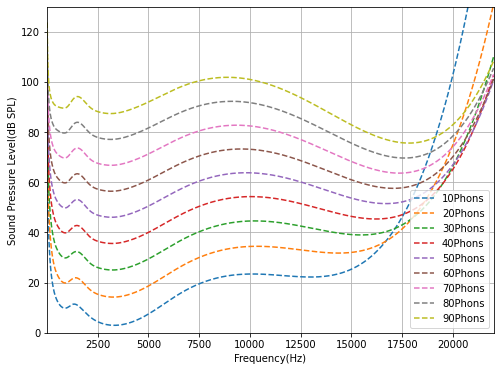

In [4]:
plt.figure(figsize=(8,6))
for index in range(9):
    phon = index * 10 + 10
    s = iso226_spl_itpl(phon)
    xs = np.linspace(20, 22000, 16384)
    ys = s(xs)
    plt.plot(xs, ys, '--', label=str(phon)+"Phons")

plt.legend()
plt.xscale("linear")
plt.grid()
plt.xlabel("Frequency(Hz)")
plt.ylabel("Sound Pressure Level(dB SPL)")
plt.xlim(20, 22000)
plt.ylim(0, 130)
plt.show()

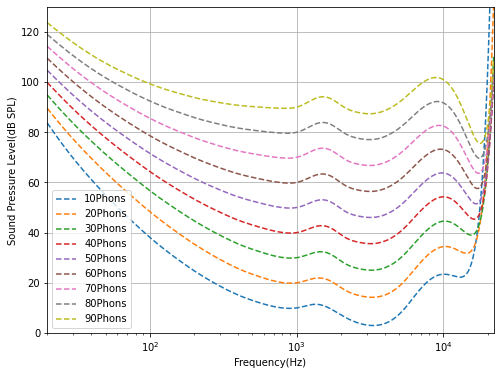

In [5]:
plt.figure(figsize=(8,6))
for index in range(9):
    phon = index * 10 + 10
    s = iso226_spl_itpl(phon)
    xs = np.linspace(20, 22000, 16384)
    ys = s(xs)
    plt.plot(xs, ys, '--', label=str(phon)+"Phons")

plt.legend()
plt.xscale("log")
plt.grid()
plt.xlabel("Frequency(Hz)")
plt.ylabel("Sound Pressure Level(dB SPL)")
plt.xlim(20, 22000)
plt.ylim(0, 130)
plt.show()

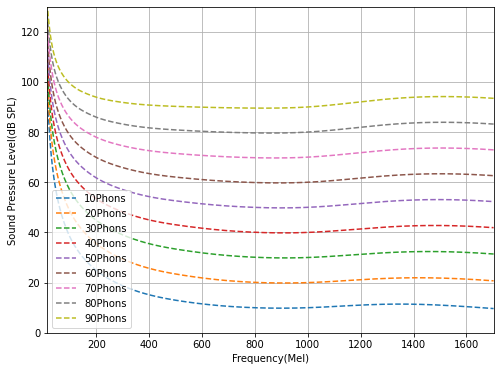

In [6]:
plt.figure(figsize=(8,6))
for index in range(9):
    phon = index * 10 + 10
    s = iso226_spl_itpl(phon)
    xs = np.linspace(20, 22000, 16384)
    mel_xs =  np.log10(1 + xs/700) * 1127
    mel_ys = s(mel_xs)
    plt.plot(mel_xs, mel_ys, '--', label=str(phon)+"Phons")

plt.legend()
plt.grid()
plt.xlabel("Frequency(Mel)")
plt.ylabel("Sound Pressure Level(dB SPL)")
start = np.log10(1 + 20/700) * 1127
end = np.log10(1 + 22000/700) * 1127
plt.xlim(start, end)
plt.ylim(0, 130)
plt.show()